In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1)

The functions derivs_orbit and rk4 are copy pasted from class. rk4_adaptive is a modified version of rk4 which adjusts the step size.

In [2]:
def rk4(x,h,derivs):
    f = derivs(x)
    f1 = derivs(x + f*h/2)
    f2 = derivs(x + f1*h/2)
    f3 = derivs(x + f2*h)
    f4 = x + h*(f + 2*f1 + 2*f2 + f3)/6
    return f4

def constant_integrator(nsteps, dt, x0, derivs):
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    for i in range(1,nsteps):   
        x[i] = rk4(x[i-1],dt,derivs)
    return x

def adaptive_integrator(h, x0, derivs):
    '''
    h = initial step size
    x0 = array of initial values
    deriv = function that evaluates derivatives
    '''
    nsteps = 50 #start with a conservative guess on number of steps
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    
    t = 0 # initial time
    err_thresh = 1e-6 # error threshold
    acc = 0 # number of points accepted
    
    while t <= (2*np.pi): 
        # calculate rk4 with step size = h
        x_big = rk4(x[acc],h,derivs)
        
        # calculate rk4 with two h/2 steps
        # step 1
        x_small_half = rk4(x[acc],h/2,derivs)
        # step 2
        x_small = rk4(x_small_half,h/2,derivs)

        # calculate error
        err = np.max(np.abs((x_big-x_small)))
        # check if x_big satisfies threshold
        if err > err_thresh:
            # reject!
            # update step size
            h = h/2
            continue
        else:
            # accept!
            t += h
            
            # update step size
            h = 2*h
            
            # make sure we land on t_final = 2pi
            t_left = 2*np.pi - t
            if t_left < h:
                h = t_left
            if t_left == 0:
                print('final t = ',t)
                x[acc+1] = x_small
                break
                
             
            # keep track of number of steps taken
            acc += 1
            
            x[acc] = x_small
        
        # concatenate new empty array to x in case x is filled up
        if (acc+1) >= nsteps:
            x_add = np.zeros((nsteps,len(x0)))
            x = np.concatenate((x,x_add))
            
    return x[:(acc+2)]

def derivs_orbit(x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

First we show how many steps it takes for rk4 to reach an error on the order of $10^{-6}$

Error =  -8.914531396841952e-06
Number of steps =  2400


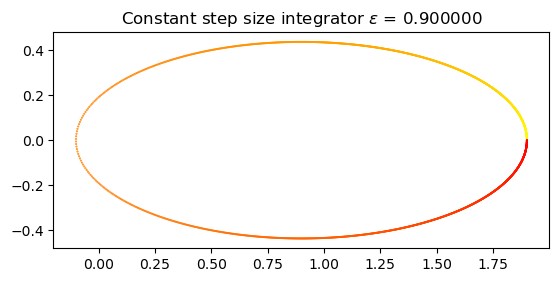

In [3]:
nsteps = 2400
dt = 2 * np.pi / (nsteps-1)
t = np.arange(nsteps)*dt

e0 = 0.9     # eccentricity
r0 = 1 + e0  # initial radius
v0 = np.sqrt(2/r0-1.)
x_start = np.array((r0,0.,0.,v0))

x = constant_integrator(nsteps,dt, x_start, derivs_orbit)

xf = x[-1] # final values
rf = np.linalg.norm((xf[0],xf[1]))  # final radius
error = rf-r0
print('Error = ', error)
print('Number of steps = ', nsteps)

plt.title('Constant step size integrator $\epsilon$ = %f'%e0)
plt.scatter(x[:,0], x[:,1], c=t, cmap='autumn_r',s=0.2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

Now we use the adaptive integrator

final t =  6.283185307179586
Error =  -1.0714291382996066e-06
Number of steps 125


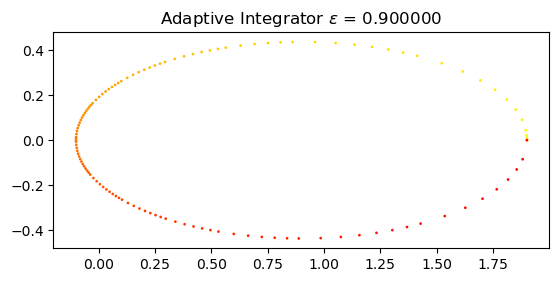

In [4]:
# estimate number of steps to establish inital step size
nsteps = 1000
dt = 2 * np.pi / (nsteps-1)

# define starting conditions of orbit
e0 = 0.9        # eccentricity
r0 = 1 + e0     # radius
v0 = np.sqrt(2/r0-1.)
x_start = np.array((r0,0.,0.,v0)) 

x = adaptive_integrator(dt, x_start, derivs_orbit)

# calculate error
xf = x[-1]
rf = np.linalg.norm((xf[0],xf[1]))
error = rf-r0
print('Error = ', error)

plt.title('Adaptive Integrator $\epsilon$ = %f'%e0)
c = np.arange((len(x[:,0])))
plt.scatter(x[:,0], x[:,1], c=c, cmap='autumn_r',s=0.9)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

print('Number of steps',len(x))


With constant step size, the integrator needed 2400 steps. The adaptive integrator on the other hand needed to take only 125 steps. This is orders of magnitude better than the constant step size integrator.